In [12]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from rdkit import Chem
import numpy as np

from utils import *

In [13]:
top5 = pd.read_csv("../data/output_matching/matchms/matchms_tol_0.01_1%I_top5.tsv", sep='\t')

In [14]:
top5_same = get_matching_rows(top5, 'query', 'reference')
merged_top5_same = append_classes(top5_same, 'query')
# Apply the function to each row of the DataFrame
merged_top5_same['true_names'] = merged_top5_same.apply(lambda row: get_true_names(row, merged_top5_same), axis=1)
# Convert the list of names to a comma-separated string
merged_top5_same['true_names'] = merged_top5_same['true_names'].apply(lambda lst: ', '.join(lst))

[14:17:50] Skipping unrecognized collection type at line 48576: MDLV30/STERAC1 BONDS=(1 7)


[14:17:50] Skipping unrecognized collection type at line 48576: MDLV30/STERAC1 BONDS=(1 7)
[14:17:51] Skipping unrecognized collection type at line 48576: MDLV30/STERAC1 BONDS=(1 7)
[14:17:51] Skipping unrecognized collection type at line 48576: MDLV30/STERAC1 BONDS=(1 7)
[14:17:51] Skipping unrecognized collection type at line 48576: MDLV30/STERAC1 BONDS=(1 7)
[14:17:52] Skipping unrecognized collection type at line 48576: MDLV30/STERAC1 BONDS=(1 7)
[14:17:52] Skipping unrecognized collection type at line 48576: MDLV30/STERAC1 BONDS=(1 7)
[14:17:53] Skipping unrecognized collection type at line 48576: MDLV30/STERAC1 BONDS=(1 7)
[14:17:53] Skipping unrecognized collection type at line 48576: MDLV30/STERAC1 BONDS=(1 7)
[14:17:53] Skipping unrecognized collection type at line 48576: MDLV30/STERAC1 BONDS=(1 7)
[14:17:54] Skipping unrecognized collection type at line 48576: MDLV30/STERAC1 BONDS=(1 7)
[14:17:54] Skipping unrecognized collection type at line 48576: MDLV30/STERAC1 BONDS=(1 7)

/home/hechth/micromamba/envs/rms/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hechth/micromamba/envs/rms/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hechth/micromamba/envs/rms/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


/home/hechth/micromamba/envs/rms/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hechth/micromamba/envs/rms/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hechth/micromamba/envs/rms/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


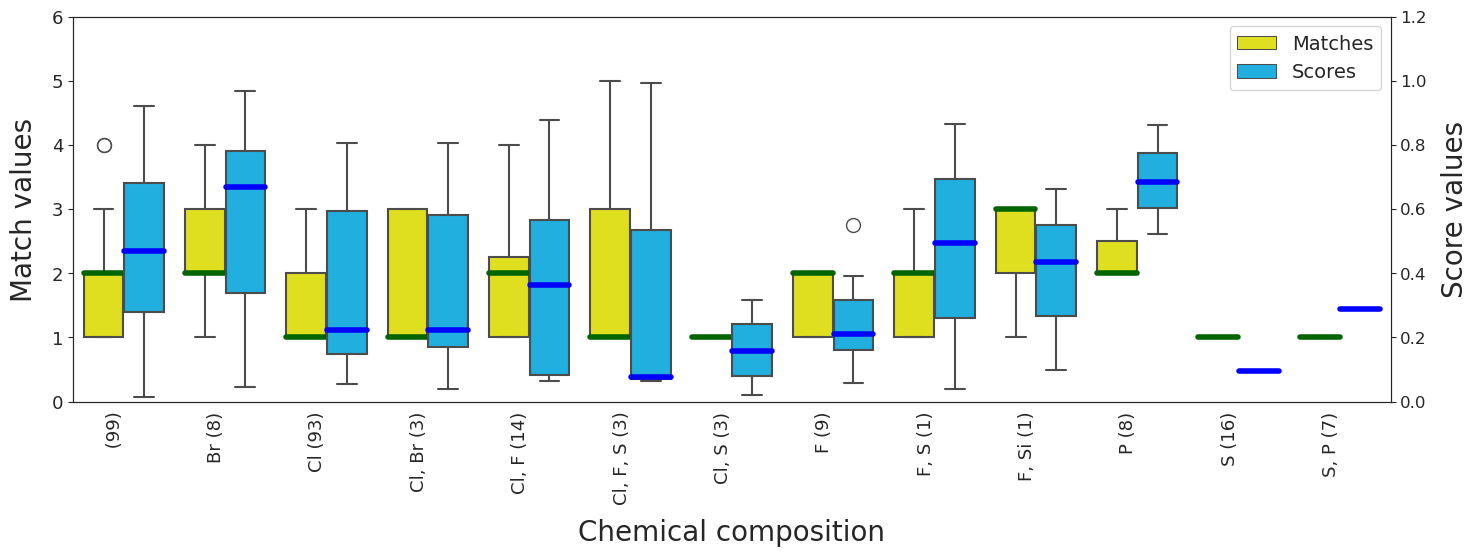

In [15]:
sns.set_style(style='white')
plt.figure(figsize=(17, 5))

# Concatenate the DataFrames in df1_list and add a 'value' column with the value 'matches'.
df1 = merged_top5_same[['query', 'reference', 'true_names', 'CosineHungarian_0.01_0.0_1.0_matches']].copy()

# Concatenate the DataFrames in df2_list and add a 'value' column with the value 'scores'.
df2 = merged_top5_same[['query', 'reference', 'true_names', 'CosineHungarian_0.01_0.0_1.0_scores']].copy()

# Concatenate df1 and df2 into a single DataFrame.
df_cat = pd.concat([df1, df2])
mdf = pd.melt(df_cat, id_vars=['query', 'reference', 'true_names'], var_name=['Number'])      # MELT

# Set the color palette
colors = ['yellow', 'deepskyblue']
sns.set_palette(sns.color_palette(colors))

ax = sns.boxplot(x="true_names", y="value", hue="Number", 
                data=mdf, hue_order=['CosineHungarian_0.01_0.0_1.0_matches',np.nan],
                medianprops={'color': 'darkgreen', 'linewidth': 4.0},
                flierprops={'marker': 'o', 'markersize': 10, 'markerfacecolor': 'none'})  # RUN PLOT   
ax2 = ax.twinx()

sns.boxplot(ax=ax2,x='true_names', y='value', hue='Number',
            data=mdf, hue_order=[np.nan, 'CosineHungarian_0.01_0.0_1.0_scores'], 
            medianprops={'color': 'b', 'linewidth': 4.0}, 
            flierprops={'marker': 'o', 'markersize': 10, 'markerfacecolor': 'none'})

ax.legend_.remove()
ax.set_ylim([0, 6])  # Set y-axis limits
ax.yaxis.set_major_locator(plt.MultipleLocator(1))  # Set major tick marks
ax.set_ylabel('Match values')  # Set y-axis label
ax.yaxis.label.set_size(20)  # Set font size of y-axis label
ax.set_xlabel('Chemical composition', fontsize=20)  # Set x-axis label and font size
ax.tick_params(axis='x', labelsize=13)  # Set font size of x-axis tick labels
ax.tick_params(axis='y', labelsize=13)  # Set font size of y-axis tick labels
ax.yaxis.labelpad = 10
ax.xaxis.labelpad = 10

# Add x-axis labels with group sizes
grouped_df = merged_top5_same.groupby('true_names')['query'].apply(list).reset_index(name='queries')
xticklabels = [f"{group} ({len(x)})" for group, x in grouped_df.values]
ax.set_xticklabels(xticklabels, rotation=90, ha='right')

ax2.legend_.remove()
ax2.set_ylim([0, 1.2])  # Set y-axis limits
ax2.yaxis.set_major_locator(plt.MultipleLocator(0.2))  # Set major tick marks
ax2.set_ylabel('Score values')  # Set y-axis label
ax2.yaxis.label.set_size(20)  # Set font size of y-axis label
ax2.tick_params(axis='y', labelsize=12)  # Set font size of y-axis tick labels
ax2.yaxis.labelpad = 10

# Change the legend labels
handles, labels = ax.get_legend_handles_labels()
labels[0] = 'Matches'
labels[1] = 'Scores'
ax.legend(handles, labels, loc='upper right', fontsize=14)

plt.savefig('../Python_scripts/chemical_composition_boxplot.png', dpi=300, bbox_inches='tight')  # SAVE PLOT AS PNG FILE
plt.show()
plt.clf()
plt.close()